구내식당 관리자 A씨는 요즘 음식 재고로 인해 스트레스를 받고 있음
구내식당에 오는 사람을 감으로 예측을 하고 있었는데 어떤 날은 적게, 어떤 날은 많게 오는 경우가 허다해서 재고 관리 측면에서 손실을 크게 보고 있음

메뉴 정보 + 식수 근무자 정보 데이터를 활용해 식수를 예측하고 재고 관리를 효율적으로 하고자함.

## 문제정의
- BX : 매장의 음식 재고를 효율적으로 관리하여 손실을 최소화하고 운영 효율성을 높이자
- CX : 적정한 식수 예측 → 식사 시간대에 음식이 부족하거나 남지 않도록 하여 고객의 불만을 줄이고 만족도를 높여보자
- DX : 식수 예측과 관련된 정보를 지속적으로 확인하고 개선
    - 본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 중식계, 석식계, 요일, 메뉴 정보
- Trigger : 최근 매장의 음식 재고 관리 문제로 인한 손실 발생 증가
- Accelerator : 메뉴 정보, 근무자의 정보, 중식 및 석식 식수 데이터 등
- Tracker : 식수 예측 정확도와 재고 손실 변화 추이 확인 및 분석

BX : 회사 입장에서 정리한 문제
CX : 고객 입장에서 정리한 문제
DX : 디지털 경험에서 정리한 문제

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib 관련 모듈을 추가로 import
import matplotlib.font_manager as fm
import matplotlib as mpl

In [2]:
# 한글 폰트 설정
# plt.rcParams['']
plt.rc('font', family = 'Gulim')
# plt.rcParams['font.family'] = 'Gulim'

# 한글이 표기가 안 될 때 ㅁㅁㅁㅁ xxxxxx
# 이렇게 표시 안 되도록 설정(한글 깨지는 것 방지)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기.
# encoding = 'cp949'
# cafeteria.csv 파일 불러와서 df에 저장
df = pd.read_csv("./data/Cafeteria.csv", encoding = "cp949")
# 한글 인코딩 : utf-8, euc-kr, cp949

- 데이터 정보

| 컬럼명                    | 설명                                     |
|--------------------------|----------------------------------------|
| 일자                     | 데이터가 수집된 날짜                    |
| 요일                     | 해당 날짜의 요일                        |
| 본사정원수               | 본사에 근무하는 전체 직원 수             |
| 본사휴가자수             | 본사에 휴가 중인 직원 수                |
| 본사출장자수             | 본사에 출장 중인 직원 수                |
| 본사시간외근무명령서승인건수 | 본사에서 승인된 시간 외 근무 명령서 건수  |
| 현본사소속재택근무자수   | 본사 소속 중 재택 근무 중인 직원 수     |
| 조식메뉴                 | 해당 날짜의 조식 메뉴                   |
| 중식메뉴                 | 해당 날짜의 중식 메뉴                   |
| 석식메뉴                 | 해당 날짜의 석식 메뉴                   |
| 중식계                   | 해당 날짜에 중식을 이용한 직원 수       |
| 석식계                   | 해당 날짜에 석식을 이용한 직원 수       |

In [4]:
# 데이터 정보 확인
df.info()
# 1205개의 행, 12개의 컬럼 (1205, 12)
# 결측치는 없음
# 일자, 요일, 메뉴 정보는 문자열 나머지는 수치형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [5]:
# 데이터 생플링
df.head(3)
# 일자는 년-월-일로 구성된 데이터(영어, 한글 아님)
# python에서 제공하는 날짜 자료형을 활용해 일자 컬럼을 처리해보자.

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [6]:
import datetime
# 날짜(시간) 관련된 연산, 비교같은 기능을 제공하는 모듈

In [7]:
# 1. 문자열 데이터를 날짜 자료형으로 변환
df['일자'] = pd.to_datetime(df['일자'])
# 2. 기존 데이터에 덮어씌우기

In [8]:
# 1. 주어진 데이터가 언제부터 언제까지 데이터인지 확인.
df['일자'].min(), df['일자'].max()
# 2016-02-01 ~ 2021-01-26

(Timestamp('2016-02-01 00:00:00'), Timestamp('2021-01-26 00:00:00'))

In [9]:
# 요일별 식수 차이를 시각화해서 확인.
# 요일별로 그룹화해서 평균 식수계 확인.
df_day = df.groupby('요일')[['중식계', '석식계']].mean()
# df[['요일', '중식계', '석식계']].groupby('요일').mean()

In [10]:
# 인덱스를 월, 화, 수, 목, 금, 순으로 바꾸기.

df_day = pd.DataFrame(df_day, index=['월', '화', '수', '목', '금'])
df_day

,중식계,석식계
월,1144.331950,538.933610
화,925.620833,520.129167
수,905.213389,363.615063
목,823.991803,480.401639
금,653.609959,404.979253


In [11]:
# 차트 배경 어둡게(다크 모드)
plt.style.use(['dark_background'])

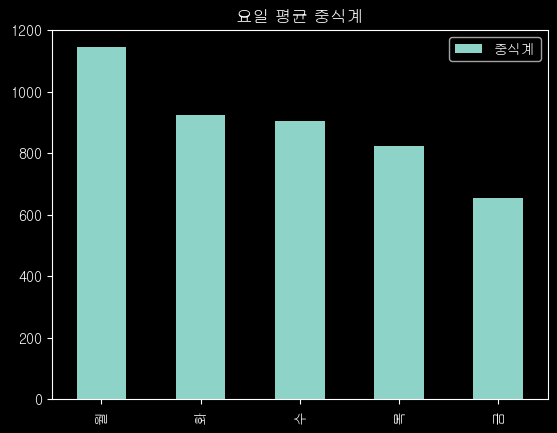

In [12]:
# df_day 활용해서 그래프 그리기
# 1. 월-금별 중식계 시각화 그래프
df_day.plot(kind = 'bar', y = '중식계')
plt.title('요일 평균 중식계')
plt.show()

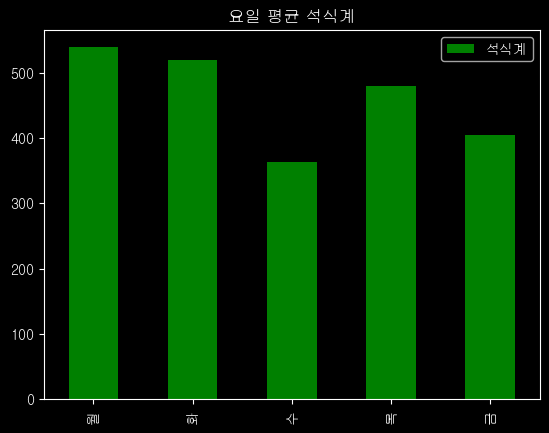

In [13]:
# 2. 월-금별 석식계 시각화 그래프
df_day.plot(kind = 'bar', y = '석식계', color = 'green')
plt.title('요일 평균 석식계')
plt.show()

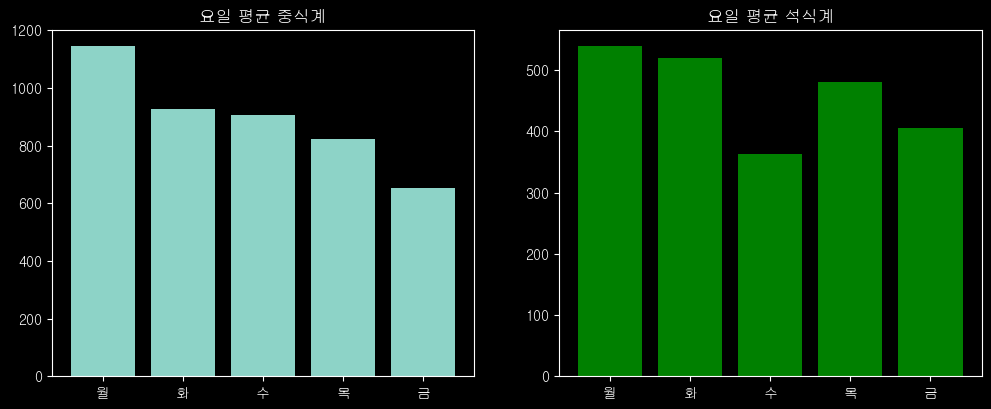

In [14]:
# 그래프를 한 개의 도화지 안에 나눠그리기.
plt.figure(figsize = (12, 4.5))

plt.subplot(1, 2, 1)
plt.bar(x = df_day.index, height = df_day['중식계'])
plt.title('요일 평균 중식계')

# 월요일이 중식계에 대한 식수가 가장 많음
# 주 초반에 직원들이 회사에 많이 출근하고 점심을 먹는 경향이 있음을 나타냄
# 주 후반으로 갈수록 식수는 감소하며, 금요일이 가장 낮은 중식계 시수를 보임

plt.subplot(1, 2, 2)
plt.bar(x = df_day.index, height = df_day['석식계'], color = 'green')
plt.title('요일 평균 석식계')

# 석식계 또한 월요일이 가장 많음을 확인
# → 월요일에 늦게까지 일하는 직원들이 많음을 의미

# 수요일에 식수가 감소함
# → 주중 중반의 수요일이라, 많은 직원들이 피로를 느낄 수 있음
# → 또는 정기적인 외부 미팅이나 회의가 잡혀있는 경우,
#    외부에서의 식사를 고려할 수 있음

# 목요일의 석식계 식수 증가
# 주 후반에 접어들며, 업무 마감을 준비하는 시기로 원인을 유추해볼 수 있음

# 금요일의 석식계 식수 감소
# 많은 직원들이 주말을 앞두고 조기 퇴근하거나,
# 사회적 약속이 많은 시기이므로 외부에서 식사하는 경우가 있는 듯 함

plt.show()

In [15]:
# 월별로 통계 확인
# datetime 자료형 활용
df['month'] = df['일자'].dt.month # 날짜별로 월만 추출
# 새로운 month 컬럼 추가

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
 12  month           1205 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(4), object(4)
memory usage: 117.8+ KB


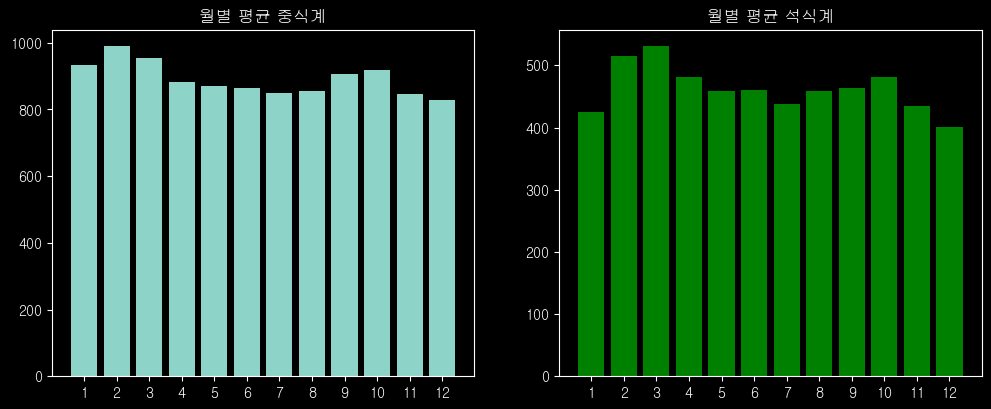

In [22]:
# 월별 중식계, 석식계 평균

# 1. df_month 변수에 월별 평균 중식계, 석식계 저장
df_month = df[['month', '중식계', '석식계']].groupby('month').mean()

# 2. 시각화(subplot 활용)
# 월별 평균 중식계, 석식계 그래프 그려보기
plt.figure(figsize = (12, 4.5))

plt.subplot(1, 2, 1)
plt.title('월별 평균 중식계')
plt.xticks(df_month.index) # 모든 x축 출력하기
plt.bar(x = df_month.index, height = df_month['중식계'])

plt.subplot(1, 2, 2)
plt.title('월별 평균 석식계')
plt.xticks(df_month.index) # 모든 x축 출력하기
plt.bar(x = df_month.index, height = df_month['석식계'], color = 'green')

plt.show()
# 2, 3월 식수가 높음 → 신입 사원 채용으로 먹는 사람의 인원 자체가 증가할 가능성이 있음
# 4~8월 휴가를 가는 사람들이 슬슬 생겨나서 인원이 감소

# 전체적으로 봤을 때는 차이가 거의 나보이지는 않음

In [23]:
df.head(3)
# 식수에 영향을 미치는 '메뉴'를 분석해보고 싶음
# 메뉴를 보고 구내식당에서 먹을지 외식을 할 건지 결정
# 메뉴 분석 전 전처리 과정이 필요함

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,month
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2


### 메뉴 전처리.

In [24]:
df['조식메뉴'][0]
# 메뉴가 공백(띄어쓰기)으로 구분되어있기는 하나 들쑥날쑥하게 구분이 되어있음
# ' ' → 로 바꿔서 확인.

'모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐어채무침  포기김치 (배추,고추가루:국내산) '

In [25]:
df['조식메뉴'][0].replace(' ', '*')
# 공백으로 나눠져 있지만 균일하지 않게 한 개, 두 개로 엉망진창 구분이 돼있음

'모닝롤/찐빵**우유/두유/주스*계란후라이**호두죽/쌀밥*(쌀:국내산)*된장찌개**쥐어채무침**포기김치*(배추,고추가루:국내산)*'

In [26]:
# 띄어쓰기 3 → 2, 띄어쓰기 2 → 1
df['조식메뉴'] = df['조식메뉴'].str.replace("   ", "  ")
df['중식메뉴'] = df['중식메뉴'].str.replace("   ", "  ")
df['석식메뉴'] = df['석식메뉴'].str.replace("   ", "  ")

df['조식메뉴'] = df['조식메뉴'].str.replace("  ", " ")
df['중식메뉴'] = df['중식메뉴'].str.replace("  ", " ")
df['석식메뉴'] = df['석식메뉴'].str.replace("  ", " ")

# 띄어쓰기 1개를 기준으로 문자열 분리

In [27]:
df['조식메뉴'][0]

'모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무침 포기김치 (배추,고추가루:국내산) '

In [28]:
df['조식메뉴'][0].replace(' ', '*')

'모닝롤/찐빵*우유/두유/주스*계란후라이*호두죽/쌀밥*(쌀:국내산)*된장찌개*쥐어채무침*포기김치*(배추,고추가루:국내산)*'

In [29]:
# 띄어쓰기를 기준으로 문자열 분리
df['조식메뉴'] = df['조식메뉴'].str.split(' ')
# 여러번 실행시키지 말기.

In [30]:
df['조식메뉴']

0       [모닝롤/찐빵, 우유/두유/주스, 계란후라이, 호두죽/쌀밥, (쌀:국내산), 된장찌...
1       [모닝롤/단호박샌드, 우유/두유/주스, 계란후라이, 팥죽/쌀밥, (쌀:국내산), 호...
2       [모닝롤/베이글, 우유/두유/주스, 계란후라이, 표고버섯죽/쌀밥, (쌀:국내산), ...
3       [모닝롤/토마토샌드, 우유/두유/주스, 계란후라이, 닭죽/쌀밥, (쌀,닭:국내산),...
4       [모닝롤/와플, 우유/두유/주스, 계란후라이, 쇠고기죽/쌀밥, (쌀:국내산), 재첩...
                              ...                        
1200    [모닝롤/페퍼로니피자, 우유/주스, 계란후라이/찐계란, 크루통크림스프/흑미밥, 아귀...
1201    [모닝롤/생크림단팥빵, 우유/주스, 계란후라이/찐계란, 누룽지탕/흑미밥, 떡국, 해...
1202    [모닝롤/BLT샌드위치, 우유/주스, 계란후라이/찐계란, 흑임자죽/흑미밥, 바지락살...
1203    [모닝롤/호박고구마오븐구이, 우유/주스, 계란후라이/찐계란, 누룽지탕/흑미밥, 감자...
1204    [모닝롤/야채샌드, 우유/주스, 계란후라이/찐계란, 참치죽/흑미밥, 홍합탕, 애호박...
Name: 조식메뉴, Length: 1205, dtype: object

In [31]:
df['중식메뉴'] = df['중식메뉴'].str.split(' ')
df['석식메뉴'] = df['석식메뉴'].str.split(' ')

In [32]:
print(df['중식메뉴'][0])
print(df['석식메뉴'][0])

['쌀밥/잡곡밥', '(쌀,현미흑미:국내산)', '오징어찌개', '쇠불고기', '(쇠고기:호주산)', '계란찜', '청포묵무침', '요구르트', '포기김치', '(배추,고추가루:국내산)', '']
['쌀밥/잡곡밥', '(쌀,현미흑미:국내산)', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치', '(김치:국내산)', '']


In [ ]:
# TF-IDF를 활용해 중요한 메뉴를 선정해보자.
# 메뉴 선정에 불필요한 정보인 원산지 삭제